# Characterization-based Error Mitigation for Quantum Computation - Workshop

### Abstract
In this lab, you will learn about **Quantum Error Suppression and Error Mitigation (QESEM)** through hands-on experiments.
QESEM enables users to run quantum circuits on noisy QPUs and obtain highly accurate, error-free results with minimal QPU time overhead, close to theoretical limits.
It is designed to mitigate errors in generic quantum circuits and it is application agnostic. It has been validated across diverse hardware platforms, including utility-scale experiments on IBM Eagle and Heron devices. The QESEM workflow stages are as follows:

1. Device characterization - maps gate fidelities and identifies coherent errors, providing real-time calibration data. this stage ensures that mitigation leverages the highest-fidelity available operations.
2. Noise-aware transpilation - generates and evaluates alternative qubit mappings, operation sets, and measurement bases, selecting the variant that minimizes estimated QPU runtime, with optional parallelization to accelerate data collection.
3. Error suppression - redefines native gates, applies Pauli twirling, and optimizes pulse-level control (on
supported platforms) to improve fidelity.
4. Circuit characterization - builds a tailored local error model and fits it to QPU measurements to quantify residual noise.
5. Error mitigation - constructs multi-type quasi-probabilistic decompositions and samples from them in an adaptive process that minimizes mitigation QPU time and sensitivity to hardware fluctuations, achieving high accuracies at large circuit volumes.

For more information about QESEM, see [Reliable high-accuracy error mitigation for utility-scale quantum circuits](https://arxiv.org/abs/2508.10997) and [On the Importance of Error Mitigation for Quantum Computation](https://arxiv.org/pdf/2503.17243) as well as [QESEM documentation](https://docs.qedma.io/).

<div>
<img src="Qesem_workflow.avif" width="800"/>
</div>

<hr style="border: 0.7px solid #bbb; margin: 10px 0;">
<hr style="border: 0.7px solid #bbb; margin: 10px 0;">


## Setup
To install the required packages, run the following commands:

In [1]:
!pip install "qiskit>=2.0.0" "qiskit-ibm-runtime>=0.40.0" "qiskit-aer>=0.17.1" "networkx>=3.5" "matplotlib==3.10.0" "tqdm>=4.67.1" "scipy" "numpy" "python-dotenv==1.2.1" "pylatexenc>=2.10"  "qiskit-ibm-catalog >=0.8.0"


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


**Note:**
1. Please verify that the API token provided to you, the qpu token and IBM instance have been correctly updated in your .env file prior to running the following cell.
2. After installing the packages and if you updated the .env file, make sure to restart the kernel before continuing.

In [1]:
#todo update the env file
import dotenv
dotenv.load_dotenv("creds_for_qiii_qiskit_function.env")

True

## Imports

In [2]:
%matplotlib inline
import importlib

import grader
import utils
import matplotlib.pyplot as plt
import numpy as np
import qiskit
import qiskit.converters
import qiskit.quantum_info
from qiskit_ibm_catalog import QiskitFunctionsCatalog
import qiskit.result
import qiskit_aer.noise
import qiskit_ibm_runtime.fake_provider
from qiskit_aer import AerSimulator
from qiskit.primitives import BackendEstimatorV2
import scipy.optimize
import tqdm
import math
import time
import os
import networkx as nx
import datetime

importlib.reload(grader)


<module 'grader' from '/Users/tasneembiadse/dev/github.com/qedma/qii-workshop/grader.py'>

<hr style="border: 0.7px solid #bbb; margin: 10px 0;">
<hr style="border: 0.7px solid #bbb; margin: 10px 0;">


## Learning Objectives

Here’s what you’ll learn in this tutorial notebook:
1. **Why error mitigation is essential:**
Understand how quantum noise impacts measurements through noisy and ideal simulations of Kicked Ising circuits (this part is based purely on Qiskit).
2. **How QESEM qiskit function works:**
Learn how to use QESEM qiskit function to mitigate noise, and explore key concepts such as active volume and mitigation runtime overhead.
(Optional: Try running QESEM on real devices.)

# Table of Contents

1. [Section 1: Understanding the Importance of Error Mitigation](#section-1-understanding-the-importance-of-error-mitigation)
   - [1.1 Use Case: Kicked Ising](#11-use-case-kicked-ising)
   - [1.2 Exercise 1: Comparing Ideal and Noisy Values](#12-exercise-1-comparing-ideal-and-noisy-values)

2. [Section 2: Introduction to QESEM](#section-2-introduction-to-qesem)
   - [QESEM Parameters Reference](#qesem-parameters-reference)
   - [2.1 Exercise 2: Applying QESEM on a simple circuit](#21-exercise-2-applying-qesem-on-a-simple-circuit)
   - [2.2 Key Concepts](#22-key-concepts)
     - [2.2.1 Volume and Active Volume](#221-volume-and-active-volume)
     - [2.2.2 QESEM Runtime Overhead](#222-qesem-runtime-overhead)
   - [2.3 Exercise 3: QPU time vs. Active Volume](#23-exercise-3-qpu-time-vs-active-volume)
   - [2.4 Exercise 4: Exploring the T ∝ 1/ε² Relationship](#24-exercise-4-exploring-the-t--1ε²-relationship)
   - [2.5 Optional Challenge – QESEM on Real Hardware](#25-optional-challenge--qesem-on-real-hardware)


<hr style="border: 0.7px solid #bbb; margin: 10px 0;">
<hr style="border: 0.7px solid #bbb; margin: 10px 0;">


# Section 1: Understanding the Importance of Error Mitigation

 Quantum computers are inherently noisy devices. Even small amounts of noise can significantly affect quantum computations, especially as circuit depth increases. In this section, we'll:

1. **Build a circuit** for the Kicked Ising model
2. **Learn the effects of noise** on different types of quantum observables

## 1.1 Use Case: Kicked Ising

The **Kicked Ising Model** [[1]](#ref2)  is a paradigmatic quantum spin chain model used to study quantum chaos, entanglement, and non-equilibrium dynamics. It consists of spin-1/2 particles (qubits) with nearest-neighbor interactions on a graph, and a periodically applied "kick".

### Model Definition

The time evolution of the kicked Ising model is governed by a periodically time-dependent Hamiltonian. The unitary evolution over one period $T$, on a 1D lattice of size $n$, is given by:

$$
U = \exp\left(-i J \sum_{j=0}^{n-2} \sigma_j^z \sigma_{j+1}^z \right) \exp\left(-i h_x \sum_{j=0}^{n-1} \sigma_j^x \right)
$$

where $\sigma_j^x, \sigma_j^z$ are Pauli matrices acting on site $j$, and $J, h_x$ are constants.

### Physical Significance

- **Quantum Chaos:** The kicked Ising model exhibits rich quantum chaotic behavior, making it a benchmark for studies of thermalization and information scrambling in many-body quantum systems.
- **Floquet Systems:** Since the system is driven periodically, it is a canonical example of a **Floquet system**, where stroboscopic (periodic) dynamics are studied.
- **Entanglement & Quantum Information:** The model is widely used to investigate entanglement growth, operator spreading, and out-of-time-ordered correlators (OTOCs).

### References
<a id="ref1"></a>
[1] Prosen, T. (2000). Exact time-correlation functions of quantum Ising chain in a kicking transversal magnetic field: Spectral analysis of the adjoint propagator in Heisenberg picture. Progress of Theoretical Physics Supplement, 139, 191-203. [https://arxiv.org/pdf/nlin.CD/0009031]


<div class="alert alert-block alert-info">
<b>Note:</b>

While in this lab we focus on exploring a 1D Kicked Ising model for simplicity, QESEM can work on arbitrary circuits and observables.

## 1.2 Exercise 1: Comparing Ideal and Noisy Values

This exercise demonstrates how quantum noise degrades computation results:

**What We'll Do:**
- **Build Kicked Ising Circuits**: Create quantum circuits simulating time evolution with increasing number of Trotter steps
- **Measure** Z Correlation Operators: Evaluate  $\left\langle Z_0 Z_1 \dots Z_{n-1} \right\rangle$ and $\left\langle Z_0 Z_1 \dots Z_{4} \right\rangle$ to probe global multi-qubit correlations
- **Compare Results**: Ideal expectation values to noisy ones


### Step 1: Preparing Kicked-Ising circuit

The following function `kicked_ising_1d` creates a quantum circuit that implements the Kicked Ising model. It applies alternating layers of RX gates (the transverse field) and RZZ gates (interaction terms) to simulate the time evolution of the system.

In [3]:
def kicked_ising_1d(num_qubits: int, theta_x: float, theta_zz: float, num_steps: int) -> qiskit.QuantumCircuit:
    """
    Parameters:
        num_qubits (int): number of qubits on chain.
        theta_x (float): Angle for RX gates.
        theta_zz (float): Angle for RZZ gates.
        num_steps (int): Number of steps.

    Returns:
        QuantumCircuit: The resulting quantum circuit.
    """
    graph = nx.path_graph(num_qubits)
    qc = qiskit.QuantumCircuit(num_qubits)

    # Precompute edge layers (alternating non-overlapping pairs)
    edges = list(graph.edges())
    even_edges = [(u, v) for (u, v) in edges if u % 2 == 0]
    odd_edges = [(u, v) for (u, v) in edges if u % 2 == 1]

    for step in range(num_steps):
        # RX on all qubits
        for q in range(num_qubits):
            qc.rx(theta_x, q)

        # Apply even and odd layers separately
        for edge_layer in [even_edges, odd_edges]:
            for u, v in edge_layer:
                qc.rzz(theta_zz, u, v)

        if step < num_steps - 1:
            qc.barrier()

    return qc

### Step 2: Kicked Ising Circuit Visualization

Here we set up the circuit experiment parameters and create a visualization of the circuit.


In [4]:
n_qubits_ex1 = 20
n_steps = 3

circ = kicked_ising_1d(n_qubits_ex1, theta_x=math.pi / 6, theta_zz=math.pi / 3, num_steps=n_steps)

print(f"Circuit 2q layers: {circ.depth(filter_function=lambda instr: len(instr.qubits) == 2)}")
print("\nCircuit structure:")

circ.draw("text", scale=0.8, fold=-1)

Circuit 2q layers: 6

Circuit structure:


┌─────────┐                     ░ ┌─────────┐                     ░ ┌─────────┐                    
 q_0: ┤ Rx(π/6) ├─■───────────────────░─┤ Rx(π/6) ├─■───────────────────░─┤ Rx(π/6) ├─■──────────────────
      ├─────────┤ │ZZ(π/3)            ░ ├─────────┤ │ZZ(π/3)            ░ ├─────────┤ │ZZ(π/3)           
 q_1: ┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■────────
      ├─────────┤           │ZZ(π/3)  ░ ├─────────┤           │ZZ(π/3)  ░ ├─────────┤           │ZZ(π/3) 
 q_2: ┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■────────
      ├─────────┤ │ZZ(π/3)            ░ ├─────────┤ │ZZ(π/3)            ░ ├─────────┤ │ZZ(π/3)           
 q_3: ┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■────────
      ├─────────┤           │ZZ(π/3)  ░ ├─────────┤           │ZZ(π/3)  ░ ├─────────┤           │ZZ(π/3) 
 q_4: ┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■────────
      ├─────────┤ │ZZ(π/3)            ░ ├─────────┤ │ZZ(π/3)            ░ ├─────────┤ │ZZ(π/3)           
 q_5: ┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■────────
      ├─────────┤           │ZZ(π/3)  ░ ├─────────┤           │ZZ(π/3)  ░ ├─────────┤           │ZZ(π/3) 
 q_6: ┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■────────
      ├─────────┤ │ZZ(π/3)            ░ ├─────────┤ │ZZ(π/3)            ░ ├─────────┤ │ZZ(π/3)           
 q_7: ┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■────────
      ├─────────┤           │ZZ(π/3)  ░ ├─────────┤           │ZZ(π/3)  ░ ├─────────┤           │ZZ(π/3) 
 q_8: ┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■────────
      ├─────────┤ │ZZ(π/3)            ░ ├─────────┤ │ZZ(π/3)            ░ ├─────────┤ │ZZ(π/3)           
 q_9: ┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■────────
      ├─────────┤           │ZZ(π/3)  ░ ├─────────┤           │ZZ(π/3)  ░ ├─────────┤           │ZZ(π/3) 
q_10: ┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■────────
      ├─────────┤ │ZZ(π/3)            ░ ├─────────┤ │ZZ(π/3)            ░ ├─────────┤ │ZZ(π/3)           
q_11: ┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■────────
      ├─────────┤           │ZZ(π/3)  ░ ├─────────┤           │ZZ(π/3)  ░ ├─────────┤           │ZZ(π/3) 
q_12: ┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■────────
      ├─────────┤ │ZZ(π/3)            ░ ├─────────┤ │ZZ(π/3)            ░ ├─────────┤ │ZZ(π/3)           
q_13: ┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■────────
      ├─────────┤           │ZZ(π/3)  ░ ├─────────┤           │ZZ(π/3)  ░ ├─────────┤           │ZZ(π/3) 
q_14: ┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■────────
      ├─────────┤ │ZZ(π/3)            ░ ├─────────┤ │ZZ(π/3)            ░ ├─────────┤ │ZZ(π/3)           
q_15: ┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■────────
      ├─────────┤           │ZZ(π/3)  ░ ├─────────┤           │ZZ(π/3)  ░ ├─────────┤           │ZZ(π/3) 
q_16: ┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■────────
      ├─────────┤ │ZZ(π/3)            ░ ├─────────┤ │ZZ(π/3)            ░ ├─────────┤ │ZZ(π/3)           
q_17: ┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■────────
      ├─────────┤           │ZZ(π/3)  ░ ├─────────┤           │ZZ(π/3)  ░ ├─────────┤           │ZZ(π/3) 
q_18: ┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) 

### Step 3: Simulation Parameters

Here we define:

1. A list of circuits to simulate (corresponding to the different number of time steps)
2. A list of observables to measure: $\langle Z_0...Z_4 \rangle$ and $\langle Z_0...Z_{n-1} \rangle$ and their labels


In [5]:
steps_range = range(1, 9)

circs_ex1 = []
for n_steps in steps_range:
    circs_ex1.append(
        kicked_ising_1d(
            n_qubits_ex1,
            theta_x=math.pi * 0.14,
            theta_zz=math.pi * 0.05,
            num_steps=n_steps,
        )
    )

# Prepare pairs of  (observables , labels)
observable_label_pairs = [
    (qiskit.quantum_info.SparsePauliOp.from_sparse_list([("Z" * 5, range(5), 1)], n_qubits_ex1), r"$Z_0Z_1...Z_{4}$"),
    (qiskit.quantum_info.SparsePauliOp.from_sparse_list([("Z" * n_qubits_ex1, range(n_qubits_ex1), 1)], n_qubits_ex1), r"$Z_0Z_1...Z_{n-1}$"),
]

### Step 4: Compute ideal values

Here we compute the ideal expectation values for each observable using exact simulation with statevectors. <br>
This gives us the theoretical values that we would obtain on a perfect quantum computer without any noise.

The following dictionary holds the ideal/noisy expectation values for every observable per step:<br>
`graphs["ideal" or "noisy"][observable label] = [Expectation of observable at steps_range[0], Expectation of observable at steps_range[1], ....]`

<div class="alert alert-block alert-success">
<b>Exercise 1.1:</b> <br>
    Complete the code for computing the ideal expectation value of "obs" after running the circuit "circ"

Hint: [Statevector Documentation](https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.quantum_info.Statevector)

In [6]:
graphs = {"ideal": {}}
graphs["ideal"]["steps_range"] = steps_range
for circ in tqdm.tqdm(circs_ex1):  # loop over circuits [one step circuit, two steps circuit ,....]
    for obs, label in observable_label_pairs:  # loop over observables and their label
        if label not in graphs["ideal"]:  # create list of ideal expectation values for every circuit
            graphs["ideal"][label] = []
        ideal_value = qiskit.quantum_info.Statevector(circ).expectation_value(obs).real
        graphs["ideal"][label].append(ideal_value)

100%|██████████| 8/8 [00:15<00:00,  1.95s/it]


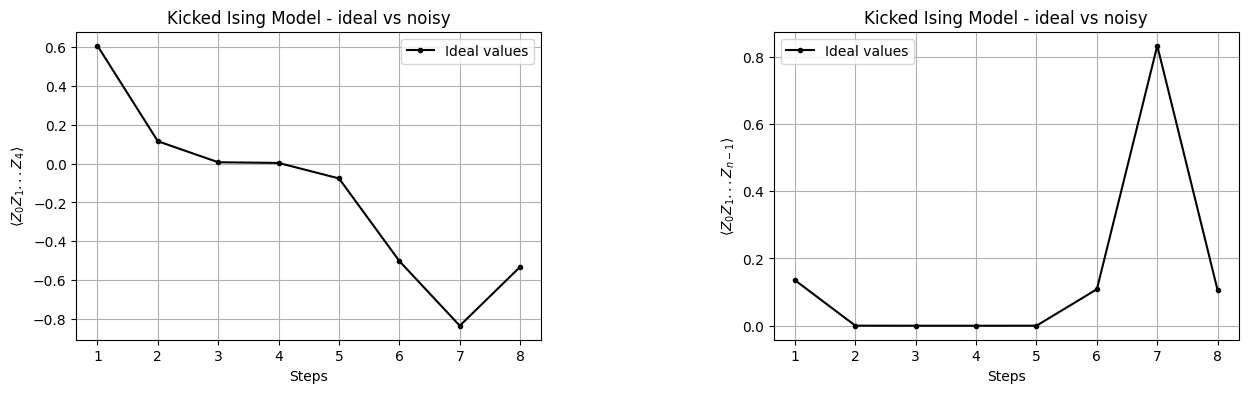

In [7]:
# Function to draw graphs from "graphs" object

# Running the function
utils.graph_plots(graphs, observable_label_pairs)

<div class="alert alert-block alert-info">
<b>Build Intuition:</b>

Which of the two observables will be more affected by noise?

### Step 5: Compute noisy values with error bars

Let's add **realistic quantum noise** to our simulation. We'll use an AerSimulator based on IBM's Fake Fez backend, which includes realistic noise models based on actual quantum hardware. <br>

In [8]:
fake_backend = qiskit_ibm_runtime.fake_provider.FakeFez()
basis_gates = fake_backend.configuration().basis_gates

noisy_backend = qiskit_aer.AerSimulator(
    method="matrix_product_state",
    noise_model=qiskit_aer.noise.NoiseModel.from_backend(fake_backend),
    basis_gates=basis_gates,
    coupling_map=fake_backend.configuration().coupling_map,
    properties=fake_backend.properties(),
    device="GPU" if "GPU" in qiskit_aer.AerSimulator().available_devices() else "CPU",
)


num_shots = 100  #### <------ Edit if too slow

Let's compute the noisy expectation values by running the circuits on the noisy simulator with finite shots. We calculate both the expectation values and their standard deviations to understand the statistical uncertainty in our measurements.

<div class="alert alert-block alert-success">
<b>Exercise 1.2:</b> <br>
    Complete the code for running "num_shots" shots of "transpiled_circ" on "noisy_backend" and extract the "counts" dictionary from the result. <br>
Change the number of shots if the simulation is too slow.<br>

Hint: [AerSimulator Documentation](https://qiskit.github.io/qiskit-aer/tutorials/1_aersimulator.html)

In [9]:
graphs["noisy"] = {"steps_range": steps_range}
graphs["noisy_std"] = {}

for circ in tqdm.tqdm(circs_ex1):
    transpiled_circ = qiskit.transpile(circ, basis_gates=basis_gates, coupling_map=fake_backend.coupling_map)
    transpiled_circ = utils.remove_idle_qubits(transpiled_circ)

    transpiled_circ.measure_all()
    counts = noisy_backend.run(transpiled_circ, shots=num_shots).result().get_counts()

    for obs, label in observable_label_pairs:
        if label not in graphs["noisy"]:
            graphs["noisy"][label] = []
            graphs["noisy_std"][label] = []

        noisy_obs_expectation = qiskit.result.sampled_expectation_value(counts, obs)  # Convert counts to expectation value
        noisy_obs_variance = (1 - qiskit.result.sampled_expectation_value(counts, obs) ** 2) / num_shots  # Only true for Paulis: P^2=I
        graphs["noisy"][label].append(noisy_obs_expectation)
        graphs["noisy_std"][label].append(noisy_obs_variance**0.5)

100%|██████████| 8/8 [00:14<00:00,  1.76s/it]


### Step 6: Plot the results

Finally, we visualize the results by plotting both the ideal and noisy expectation values as a function of the number of Trotter steps.

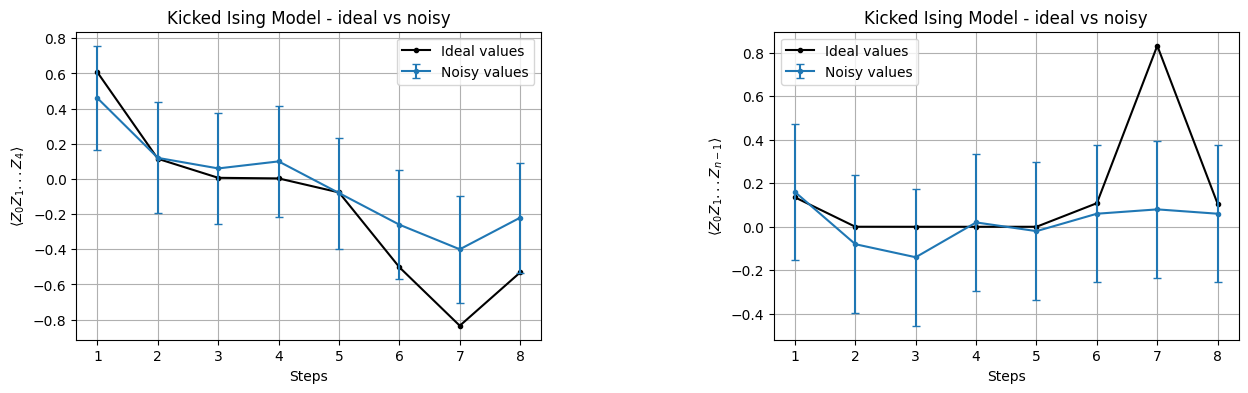

In [10]:
utils.graph_plots(graphs, observable_label_pairs)

<div class="alert alert-block alert-info">
<b>Build intuition:</b> <br>


- As circuits get deeper, quantum noise accumulates and the gap between ideal and noisy values grows. QESEM allows to run deeper circuits and still get meaningful results.
- The decay of the noisy value is controlled by the number of noisy operations the observable is sensitive to. The $\langle Z0...Z19 \rangle$ observable decays much more than $\langle Z0...Z4 \rangle$ because its lightcone spans the entire circuit.

<hr style="border: 0.7px solid #bbb; margin: 10px 0;">
<hr style="border: 0.7px solid #bbb; margin: 10px 0;">


# Section 2: Introduction to QESEM Qiskit Function

Now that we've seen how dramatically noise affects quantum computations, let's explore how to use **QESEM** qiskit function to mitigate these errors.

### How QESEM Works

QESEM combines two approaches:

1. **Error Suppression**: Reduce the unitary part of the noise. It is based on QESEM's characterization.
2. **Error Mitigation**: Use classical post-processing to estimate what the results would have been without noise.

### QESEM Parameters Reference
During this section we will guide you through the main parameters and explain each one.
There are more advanced parameters which we won't cover, see an elaborate explanation about all the parameters [here](https://quantum.cloud.ibm.com/docs/en/guides/qedma-qesem#function-parameters).

## 2.1 Exercise 2: Applying QESEM on a simple circuit

### Step 1: Set up IBM credentials and load the QESEM function


In [11]:
IBM_token = os.getenv("IBM_TOKEN")
channel = os.getenv("CHANNEL")
ibm_instance = os.getenv("IBM_INSTANCE")
catalog = QiskitFunctionsCatalog(channel=channel,
                                 token=IBM_token,
                                 instance=ibm_instance)
qesem_function = catalog.load("qedma/qesem")

### Step 2: Prepare Circuit and Observables
The following circuit prepares the state $|\psi\rangle = 0.6|0000\rangle+0.8|1111\rangle $

We will measure the average magnetization observable:<br>
avg_magnetization_ex2 = $\frac{1}{4} \sum_j Z_j$ <br>

In [12]:
circ_ex2 = qiskit.QuantumCircuit(4)
circ_ex2.ry(0.927 * 2, 0)
circ_ex2.cx(0, 1)
circ_ex2.cx(1, 2)
circ_ex2.cx(2, 3)

avg_magnetization_ex2 = qiskit.quantum_info.SparsePauliOp.from_sparse_list([("Z", [q], 1 / 4) for q in range(4)], num_qubits=4)

obs_list_ex2 = [avg_magnetization_ex2]

circ_ex2.draw("text", scale=0.7)  # assign to variable

┌───────────┐               
q_0: ┤ Ry(1.854) ├──■────────────
     └───────────┘┌─┴─┐          
q_1: ─────────────┤ X ├──■───────
                  └───┘┌─┴─┐     
q_2: ──────────────────┤ X ├──■──
                       └───┘┌─┴─┐
q_3: ───────────────────────┤ X ├
                            └───┘

### Step 3: Empirical Time Estimation

Users would typically want to know how much QPU time is required for their experiment.
However, this is considered a hard problem for classical computers.<br>
QESEM offers two modes of time estimation to inform users about the feasibility of their experiments:
1. Analytical time estimation - provides a very rough estimation and requires no QPU time. This can be used to test if a transpilation pass would potentially reduce the QPU time.
2. Empirical time estimation (demonstrated here) - provides a more accurate estimation and uses a few minutes of QPU time.

In both cases, QESEM outputs the time estimation for reaching the required precision for <b>all</b> observables.

<div class="alert alert-block alert-warning">
<b>Warning:</b> The QPU time estimation changes from one backend to another. Therefore, when executing QESEM, make sure to run it on the same backend that was selected when obtaining the QPU time estimation.

In [13]:
# Start a job for empirical time estimation
job = qesem_function.run(pubs=[(circ_ex2, obs_list_ex2)],
                         instance=ibm_instance,
                         backend_name="fake_fez",
                         options={
                             "estimate_time_only": "empirical",  # "empirical" - gets actual time estimates without running full mitigation
                              "max_execution_time": 240,          # Limits the QPU time, specified in seconds.
                              "default_precision": 0.1,
                         }
                         )

In [14]:
# Get the result object (blocking method). Use job.status() in a loop for non-blocking. This may take about
result = job.result()

In [15]:
print(f"Empirical time estimation (sec): {result[0].metadata['time_estimation_sec']}")

Empirical time estimation (sec): 300


### Step 4: Use QESEM to estimate the expectation values

<div class="alert alert-block alert-success">
<b>Exercise 2:</b> <br>
    Use QESEM to estimate the expectation values of "avg_magnetization_ex2" observable on the state generated by circ_ex2.  <br>
    Start the job for which you ran the empirical time estimation above.


<a id="tips"></a>
<div class="alert alert-block alert-info">

<b> Here -> </b> use `max_execution_time` option, this allows you to limit the QPU time, and is specified in seconds. After the time limit is reached, QESEM stops sending new circuits. Circuits that have already been sent continue running, you can see detailed explanation [here](https://quantum.cloud.ibm.com/docs/en/guides/qedma-qesem#options).
Note: QESEM will end its run when it reaches the target precision or when it reaches `max_execution_time`, whichever comes first.
We will define max execution time as 900 secs. This setting is mainly relevant for real hardware experiments and will not limit simulation-based examples.

In [16]:
max_execution_time_ex2 = 900 #seconds(int)

### Test parameters

In [17]:
message = grader.grade_ex2_qf(max_execution_time_ex2=900)
print(message)

Congratulations! 🎉 Your answer is correct.


In [18]:
# start QESEM mitigation job:
#the pubs = [(circuit, [obs1,obs2,obs3], parameter_values, precision)]
full_job = qesem_function.run(
                                pubs=[(circ_ex2, obs_list_ex2, [], 0.1)],
                                instance=ibm_instance,
                                backend_name="fake_fez",
                                options={
                                    "max_execution_time": max_execution_time_ex2,
                                }
)

In [21]:
print(full_job.status())

RUNNING: OPTIMIZING_FOR_HARDWARE


### Step 5: Reading the results

In [22]:
result = full_job.result()  # Blocking - takes 3-5 minutes
noisy_results = result[0].metadata["noisy_results"]

print("-" * 10)
print("Observable: " +"Average Magnetization")
print(f"Ideal: {qiskit.quantum_info.Statevector(circ_ex2).expectation_value(obs_list_ex2[0]).real}")
print(f"Noisy: {noisy_results.evs[0]} \u00b1 {noisy_results.stds[0]}")
print(f"QESEM: {result[0].data.evs[0]} \u00b1 {result[0].data.stds[0]}")

print("-" * 10)
# Some of the data gathered during a QESEM run.
print(f"Gate fidelities found: {result[0].metadata['gate_fidelities']}")

----------
Observable: Average Magnetization
Ideal: -0.2794331326637851
Noisy: -0.27399999999999997 ± 0.006811368206322816
QESEM: -0.28452154430837934 ± 0.0034494896664021835
----------
Gate fidelities found: {'CZ': 0.9951799737921522, 'ID1Q': 0.9994592549287301}


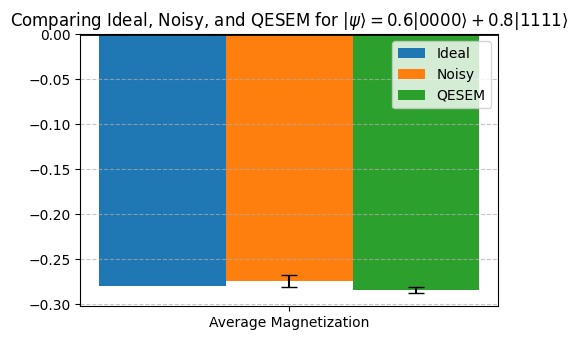

In [23]:
x = np.arange(1)  # Only one observable
width = 0.18

# Values
ideal_val = qiskit.quantum_info.Statevector(circ_ex2).expectation_value(avg_magnetization_ex2).real
noisy_val = noisy_results.evs[0]
qe_val = result[0].data.evs[0]

# Errors
noisy_err = noisy_results.stds[0]
qe_err = result[0].data.stds[0]

#plotting the bars
fig, ax = plt.subplots(figsize=(5, 3.5))

ax.bar(x - width, [ideal_val], width, label="Ideal", color="#1f77b4")
ax.bar(x, [noisy_val], width, label="Noisy", yerr=[noisy_err], capsize=6, color="#ff7f0e")
ax.bar(x + width, [qe_val], width, label="QESEM", yerr=[qe_err], capsize=6, color="#2ca02c")

ax.set_xticks(x)
ax.set_xticklabels(["Average Magnetization"])
ax.set_title(
    r"Comparing Ideal, Noisy, and QESEM for $|\psi\rangle = 0.6|0000\rangle + 0.8|1111\rangle$"
)
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.7)
ax.axhline(0, color="black", linewidth=2)

plt.tight_layout()
plt.show()

## 2.2 Key Concepts

### 2.2.1 Volume and Active Volume

A key figure of merit for quantifying the hardness of both error mitigation and classical simulation for a given circuit and observable is **active volume**: The number of two-qubit gates affecting the observable in the circuit. Different circuits and observables have different **active volumes**, which affects how hard they are to error-mitigate.

The active volume depends on:
- Circuit depth and width
- Observable weight (number of non-identity Pauli operators)
- Circuit structure (light cone of the observable)

For further details, see the talk from the [2024 IBM Quantum Summit](https://www.youtube.com/watch?v=Hd-IGvuARfE&t=1730s&ab_channel=IBMResearch).

<div>
<img src="active_vol.svg" />
</div>

### 2.2.2 QESEM Runtime Overhead

The QPU time behaves roughly like:
$$T_{QPU} \approx \left(\frac{A}{\epsilon^2}\right) \times e^{C \times IF \times V_{active}} + B$$
Where:
- B overhead of gate optimization and error characterization
- precision $\epsilon$ absolute error in expectation value
- $ IF \times V_{active} $ infidelity-per-gate times active volume. The active volume only includes gates within the active light-cone.

The **overhead** of error mitigation tells us how many additional quantum resources we need to achieve a target precision.

## 2.3 Exercise 2: QPU time vs. Active Volume
In this section we'll fix the number of steps and the precision, and compare the QPU time for the two observables in Exercise 1.


<div class="alert alert-block alert-success">
<b>Exercise 3:</b> <br>
    Use QESEM's <b>analytical</b> time estimation for measuring the expectation of $\langle Z_0...Z_4\rangle$ and $\langle Z_0...Z_{n-1}\rangle$ of the state generated by a few steps of the Kicked Ising model.<br>
    Set the default_precision to 0.02.



In [24]:
# Set the options parameter for the QESEM job by the instruction:
precision = 0.02
estimate_time_only = "analytical"

### Test parameters

In [25]:
message = grader.grade_ex3_qf(precision, estimate_time_only)
print(message)

Congratulations! 🎉 Your answer is correct.


### Start a jobs only if parameter check passed

In [53]:
if message == grader.CORRECT_MESSAGE:
    print("Starting jobs")
    selected_step = 6  # number of steps in the circuit.
    num_qubits_ex3 = 20

    circ = kicked_ising_1d(
        num_qubits_ex3,
        theta_x=math.pi * 0.14,
        theta_zz=math.pi * 0.05,
        num_steps=selected_step,
    )

    # Prepare pairs of  (observables , labels)
    observable_label_pairs_ex3 = [
        (qiskit.quantum_info.SparsePauliOp.from_sparse_list([("Z" * 5, range(5), 1)], num_qubits_ex3), r"$Z_0Z_1...Z_{4}$"),
        (qiskit.quantum_info.SparsePauliOp.from_sparse_list([("Z" * num_qubits_ex3, range(num_qubits_ex3), 1)], num_qubits_ex3), r"$Z_0Z_1...Z_{n-1}$"),
    ]

    volume_jobs: list[datetime.timedelta] = []
    for observable, obs_label in observable_label_pairs_ex3:
        # run analytical time estimation on each observable separately. Takes about 3 minutes
        # Start a job for empirical time estimation
        job = qesem_function.run(pubs=[(circ, [observable], [], precision)],
                                 instance=ibm_instance,
                                 backend_name="fake_fez",
                                 options={
                                     "estimate_time_only": estimate_time_only,
                                 }
                                 )

        #get the result and extract the time estimation from metadata
        result = job.result()
        print(f"Analytical time estimation for observable {obs_label}: {        result[0].metadata['time_estimation_sec'] / 60} min")
        # print('yes')

else:
    print("Parameters check failed. Jobs did not start")

Starting jobs
Analytical time estimation for observable $Z_0Z_1...Z_{4}$: 30.0 min
Analytical time estimation for observable $Z_0Z_1...Z_{n-1}$: 90.0 min


<div class="alert alert-block alert-info">
<b>Build intuition:</b> While the analytical time estimation is very rough (resolution of 30 minutes) and pessimistic, it still captures the difference in the active volumes of the two observables fairly quickly, and without using any QPU time.

## 2.4 Exercise 4: Exploring the $T \propto \frac{1}{\varepsilon^2}$ Relationship

In this exercise, we will investigate **how QPU time scales with precision requirements**.
### Step 1: Create and visualize the test circuit

We'll create a single Kicked Ising circuit to test the precision-time relationship. This circuit will have enough complexity to show clear scaling behavior while remaining manageable for the experiment.

<div class="alert alert-block alert-success">

<b> Exercise 4.1:</b> <br>
Complete the code. Use the function kicked_ising_1d() defined in Exercise 1 to create the circuit circ_ex4. Be sure to use the variables defined below n_qubits_ex4, n_steps_ex4, theta_x_ex4, theta_zz_ex4.
</div>

In [26]:
n_qubits_ex4 = 5  # Number of qubits (enough to see scaling effects)
n_steps_ex4 = 10  # Number of Trotter steps (creates sufficient circuit depth)
theta_x_ex4 = math.pi / 6  # Rotation angle for X gates (transverse field strength)
theta_zz_ex4 = math.pi / 3  # Rotation angle for ZZ gates (interaction strength)

# Create the Kicked Ising circuit that will be used for precision testing (Hint: `kicked_ising_1d`)
circ_ex4 = kicked_ising_1d(n_qubits_ex4, theta_x=theta_x_ex4, theta_zz=theta_zz_ex4, num_steps=n_steps_ex4)

In [27]:
message = grader.grade_ex_4_1(circ_ex4)
print(message)

Congratulations! 🎉 Your answer is correct.


In [28]:
print(f"Circuit 2q layers: {circ_ex4.depth(filter_function=lambda instr: len(instr.qubits) == 2)}")
print("\nCircuit structure:")

circ_ex4.draw("text", scale=1, fold=-1)

Circuit 2q layers: 20

Circuit structure:


┌─────────┐                     ░ ┌─────────┐                     ░ ┌─────────┐                     ░ ┌─────────┐                     ░ ┌─────────┐                     ░ ┌─────────┐                     ░ ┌─────────┐                     ░ ┌─────────┐                     ░ ┌─────────┐                     ░ ┌─────────┐                    
q_0: ┤ Rx(π/6) ├─■───────────────────░─┤ Rx(π/6) ├─■───────────────────░─┤ Rx(π/6) ├─■───────────────────░─┤ Rx(π/6) ├─■───────────────────░─┤ Rx(π/6) ├─■───────────────────░─┤ Rx(π/6) ├─■───────────────────░─┤ Rx(π/6) ├─■───────────────────░─┤ Rx(π/6) ├─■───────────────────░─┤ Rx(π/6) ├─■───────────────────░─┤ Rx(π/6) ├─■──────────────────
     ├─────────┤ │ZZ(π/3)            ░ ├─────────┤ │ZZ(π/3)            ░ ├─────────┤ │ZZ(π/3)            ░ ├─────────┤ │ZZ(π/3)            ░ ├─────────┤ │ZZ(π/3)            ░ ├─────────┤ │ZZ(π/3)            ░ ├─────────┤ │ZZ(π/3)            ░ ├─────────┤ │ZZ(π/3)            ░ ├─────────┤ │ZZ(π/3)            ░ ├─────────┤ │ZZ(π/3)           
q_1: ┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■────────
     ├─────────┤           │ZZ(π/3)  ░ ├─────────┤           │ZZ(π/3)  ░ ├─────────┤           │ZZ(π/3)  ░ ├─────────┤           │ZZ(π/3)  ░ ├─────────┤           │ZZ(π/3)  ░ ├─────────┤           │ZZ(π/3)  ░ ├─────────┤           │ZZ(π/3)  ░ ├─────────┤           │ZZ(π/3)  ░ ├─────────┤           │ZZ(π/3)  ░ ├─────────┤           │ZZ(π/3) 
q_2: ┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■────────
     ├─────────┤ │ZZ(π/3)            ░ ├─────────┤ │ZZ(π/3)            ░ ├─────────┤ │ZZ(π/3)            ░ ├─────────┤ │ZZ(π/3)            ░ ├─────────┤ │ZZ(π/3)            ░ ├─────────┤ │ZZ(π/3)            ░ ├─────────┤ │ZZ(π/3)            ░ ├─────────┤ │ZZ(π/3)            ░ ├─────────┤ │ZZ(π/3)            ░ ├─────────┤ │ZZ(π/3)           
q_3: ┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■─────────░─┤ Rx(π/6) ├─■─────────■────────
     ├─────────┤           │ZZ(π/3)  ░ ├─────────┤           │ZZ(π/3)  ░ ├─────────┤           │ZZ(π/3)  ░ ├─────────┤           │ZZ(π/3)  ░ ├─────────┤           │ZZ(π/3)  ░ ├─────────┤           │ZZ(π/3)  ░ ├─────────┤           │ZZ(π/3)  ░ ├─────────┤           │ZZ(π/3)  ░ ├─────────┤           │ZZ(π/3)  ░ ├─────────┤           │ZZ(π/3) 
q_4: ┤ Rx(π/6) ├───────────■─────────░─┤ Rx(π/6) ├───────────■─────────░─┤ Rx(π/6) ├───────────■─────────░─┤ Rx(π/6) ├───────────■─────────░─┤ Rx(π/6) ├───────────■─────────░─┤ Rx(π/6) ├───────────■─────────░─┤ Rx(π/6) ├───────────■─────────░─┤ Rx(π/6) ├───────────■─────────░─┤ Rx(π/6) ├───────────■─────────░─┤ Rx(π/6) ├───────────■────────
     └─────────┘                     ░ └─────────┘                     ░ └─────────┘                     ░ └─────────┘                     ░ └─────────┘                     ░ └─────────┘                     ░ └─────────┘                     ░ └─────────┘                     ░ └─────────┘                     ░ └─────────┘

### Step 2: Submit time estimation jobs with different precision values

We'll submit multiple QESEM jobs, each with a different precision requirement (ε). The range from 0.005 to 0.06 covers both high-precision (expensive) and moderate-precision (cheaper) regimes.

The observable: $\langle Z_0...Z_4 \rangle$. <br>


**Empirical time estimation**: We will use "empirical" time estimation this setting performs a small execution on the QPU without running full mitigation. This usually takes a few minutes per estimation and is more reliable than the "analytical" estimation.

In [88]:
backend_name_fake = "fake_fez"
precisions_ex4 = [0.005, 0.01, 0.03, 0.05]
observable_ex4 = qiskit.quantum_info.SparsePauliOp.from_sparse_list([("Z" * n_qubits_ex4, range(n_qubits_ex4), 1)], n_qubits_ex4)  # Z_0..Z_{n-1}

# Initialize list to store job IDs
jobs_ex4 = []
time_estimations = []

In [89]:
if message == grader.CORRECT_MESSAGE:
    # Loop through each precision value
    for precision in precisions_ex4:
        print(f"Submitting job with precision: {precision:.3f}")

        job = qesem_function.run(
            pubs=[(circ_ex4, [observable_ex4], [], precision)],
            instance=ibm_instance,
            backend_name="fake_fez",
            options={
                "estimate_time_only": "empirical",
            }
        )

        # Store the job ID
        jobs_ex4.append(job)
        print(f"Job submitted")

    print("\nAll jobs submitted!")

    start_time = time.time()
else:
    print("Parameter check failed. Jobs did not start")

Submitting job with precision: 0.005
Job submitted
Submitting job with precision: 0.010
Job submitted
Submitting job with precision: 0.030
Job submitted
Submitting job with precision: 0.050
Job submitted

All jobs submitted!


### Step 3: Monitor job progress

Since time estimation jobs can take several minutes to complete, we'll monitor their progress. This gives us real-time feedback on when all jobs are finished. Might take approximately 14 minutes (tested on fake_fez).

In [90]:
print("Monitoring job completion...   (this takes around 14 minutes, tested on fake_fez, you may break and return later)")
print(f"Total jobs: {len(jobs_ex4)}")
print("-" * 30)

while True:  # Each job performs device characterization to estimate QPU time requirements
    # Count how many jobs are done
    done_count = 0
    for job in jobs_ex4:  # Jobs with smaller ε values may take longer to process
        if job.status() == "DONE":
            done_count += 1

    # Show current status
    elapsed_time = time.time() - start_time
    timestamp = datetime.datetime.now().strftime("%H:%M:%S")
    print(f"[{timestamp}] {done_count}/{len(jobs_ex4)} jobs completed (elapsed: {elapsed_time/60:.1f} min)")

    # Check if all jobs are done
    if done_count == len(jobs_ex4):
        print(f"\nAll jobs completed!")
        break

    # Wait 1 minute before next check
    time.sleep(60)

end_time = time.time()
print(f"Total time: {(end_time - start_time)/60:.1f} minutes")

Monitoring job completion...   (this takes around 14 minutes, tested on fake_fez, you may break and return later)
Total jobs: 4
------------------------------
[09:55:50] 0/4 jobs completed (elapsed: 0.2 min)
[09:56:56] 0/4 jobs completed (elapsed: 1.3 min)
[09:58:04] 0/4 jobs completed (elapsed: 2.4 min)
[09:59:12] 1/4 jobs completed (elapsed: 3.5 min)
[10:00:17] 2/4 jobs completed (elapsed: 4.6 min)
[10:01:23] 2/4 jobs completed (elapsed: 5.7 min)
[10:02:28] 4/4 jobs completed (elapsed: 6.8 min)

All jobs completed!
Total time: 6.8 minutes


### Step 4: Extract time estimation results

Once all jobs are complete, we extract the QPU time estimates from each job's metadata. These time estimates represent how long QESEM would need to achieve the requested precision.

In [91]:
# Once jobs are complete, extract time estimations
time_estimations = []

print("\nExtracting time estimations from jobs...")
for i, job in enumerate(jobs_ex4):  # Loop through all completed jobs
    print(f"Getting time estimation for job {i+1}")

    # Get the result and extract time estimation
    time_estimate_result = job.result()
    time_estimation_sec = time_estimate_result[0].metadata['time_estimation_sec']

    # Store the time estimation
    time_estimations.append(time_estimation_sec)
    print(f"Time estimation: {time_estimation_sec} seconds")

print(f"\nAll time estimations extracted!")


Extracting time estimations from jobs...
Getting time estimation for job 1
Time estimation: 1500 seconds
Getting time estimation for job 2
Time estimation: 600 seconds
Getting time estimation for job 3
Time estimation: 300 seconds
Getting time estimation for job 4
Time estimation: 300 seconds

All time estimations extracted!



### Step 5: Visualize the results

We'll create a standard linear plot to visualize how QPU time varies with precision. This gives us an intuitive view of the relationship.

**Expected Pattern**: Time estimates should increase dramatically as precision requirements become more stringent (smaller ε).

0.0005087015346688863
Fitted parameters:
A = 0.0005
B = 4.70
Function: T = 0.0005/ε² + 4.70
Data points: 4


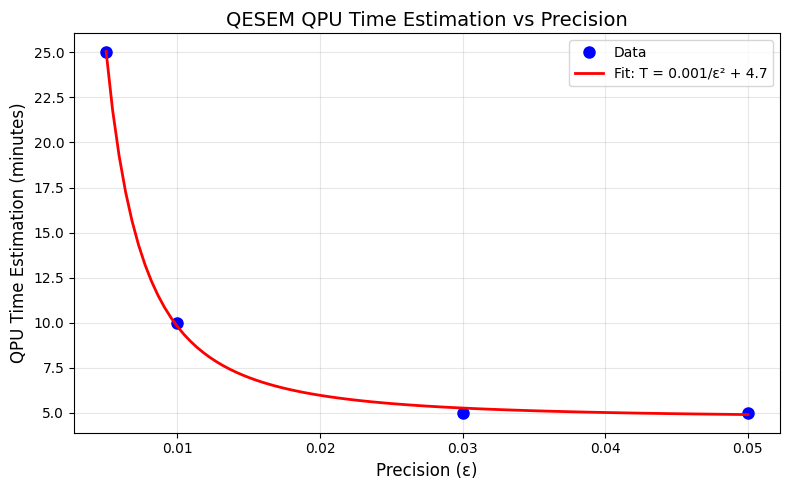

In [92]:
# Define the plotting function to visualize QPU time vs precision
def plot_qpu_time_vs_precision(precisions: list[float], time_estimations_sec: list[float], title_suffix: str = "") -> None:
    """
    Plot QPU time estimation vs precision with curve fitting

    Args:
        precisions: Array of precision values (ε)
        time_estimations_sec: Array of time estimations in seconds
        title_suffix: Optional suffix to add to the plot title
    """
    # Convert time estimations from seconds to minutes
    time_estimations_min = np.array(time_estimations_sec) / 60

    # Define the fitting function: T = A/precision^2 + B
    def fit_function(precisions: list[float], a: float, b: float) -> list[float]:
        return [a / (p**2) + b for p in precisions]

    # Perform the curve fit using time
    popt, _ = scipy.optimize.curve_fit(fit_function, precisions, time_estimations_min)
    a_fit, b_fit = popt

    # Create a smooth curve for plotting the fit
    precision_smooth = np.linspace(min(precisions), max(precisions), 100).tolist()
    time_fit = fit_function(precision_smooth, a_fit, b_fit)

    plt.figure(figsize=(8, 5))
    plt.plot(precisions, time_estimations_min, "o", markersize=8, color="blue", label="Data")
    plt.plot(
        precision_smooth,
        time_fit,
        "-",
        linewidth=2,
        color="red",
        label=f"Fit: T = {a_fit:.3f}/ε² + {b_fit:.1f}",
    )
    plt.xlabel("Precision (ε)", fontsize=12)
    plt.ylabel("QPU Time Estimation (minutes)", fontsize=12)
    plt.title(f"QESEM QPU Time Estimation vs Precision{title_suffix}", fontsize=14)

    plt.locator_params(axis="y", nbins=10)  # Increase number of y-axis ticks
    plt.grid(True, alpha=0.3)
    plt.legend()
    print(a_fit)
    # Display fit parameters
    print("Fitted parameters:")
    print(f"A = {a_fit:.4f}")
    print(f"B = {b_fit:.2f}")
    print(f"Function: T = {a_fit:.4f}/ε² + {b_fit:.2f}")
    print(f"Data points: {len(precisions)}")

    plt.tight_layout()
    plt.show()


# Create the initial plot with Steps 2-5 data
plot_qpu_time_vs_precision(precisions_ex4, time_estimations)

And indeed we can see the expected functional dependence of:
$$T_{QPU} \approx \frac{\tilde{A}}{\epsilon^2} + B$$
Where:
- $\tilde A={A} \times e^{C \times IF \times V_{active}}$
- $A$ is a constant that depends on the circuit and the expectation value
- $B$ is overhead due to gate optimization and error characterization
- $C$ is a constant between 2-4 that depends on the details of the error mitigation method.

### Step 6: Execute with error mitigation

Now let's run the actual QESEM error mitigation on our circuit with a simulated backend.

<div class="alert alert-block alert-success">

<b> Exercise 4.2:</b>

Look at the results of the QPU time vs precision graph above and think which precision you would like for your full execution (on a noisy simulator).
Complete the QESEM job parameters accordingly.
We will run an empirical time estimation for your desired precision to predict QPU resource requirements before running the full QESEM mitigation.

</div>

<div class="alert alert-block alert-info">
<b>Tip:</b> Use a moderate precision for reasonable execution time while still demonstrating the mitigation capabilities.

In [93]:
precision_ex4_2 = 0.04
circuit_ex4_2 = circ_ex4
observables_ex4_2 = [observable_ex4]
backend_ex4_2 = "fake_fez"
estimate_time_only_ex4_2 = "empirical"

### Test parameters

In [94]:
message = grader.grade_ex_4_2_qf(
    precision_ex4_2=precision_ex4_2,
    circuit_ex4_2=circuit_ex4_2,
    observables_ex4_2=observables_ex4_2,
    backend_ex4_2=backend_ex4_2,
    estimate_time_only_ex4_2=estimate_time_only_ex4_2,
)
print(message)

Congratulations! 🎉 Your answer is correct.


### Start a job only if parameter check passed

In [95]:
if message == grader.CORRECT_MESSAGE:  # Run the job only if parameters are correct
    # Start a job
    # Get time estimation first (quick empirical check)

    job_ex4_2 = qesem_function.run(
            pubs=[(circuit_ex4_2, observables_ex4_2, [], precision_ex4_2)],
            instance=ibm_instance,
            backend_name=backend_ex4_2,
            options={
                "estimate_time_only": estimate_time_only_ex4_2,
            }
        )
    print(f"Time estimation job submitted: {job_ex4_2.job_id}")
    print(f"with precision: {precision_ex4_2}")

else:
    print(message)
    print("Parameter check failed. Job did not start.")

Time estimation job submitted: e1cdf9b4-37f8-43e1-b440-a20f93c6bb81
with precision: 0.04


<a id="tips"></a>
<div class="alert alert-block alert-info">

<b> Tip:</b> Use this code cell to check your job's status.

In [113]:
job_ex4_2.status()

'RUNNING'

Extract the time estimation from Step 6a and add it to our precision vs. QPU time graph to see how the new data point fits the T ∝ 1/ε² relationship.

Step 6 time estimation: 300 seconds

Updated graph with Step 6 data point:
0.00050884535929113
Fitted parameters:
A = 0.0005
B = 4.69
Function: T = 0.0005/ε² + 4.69
Data points: 5


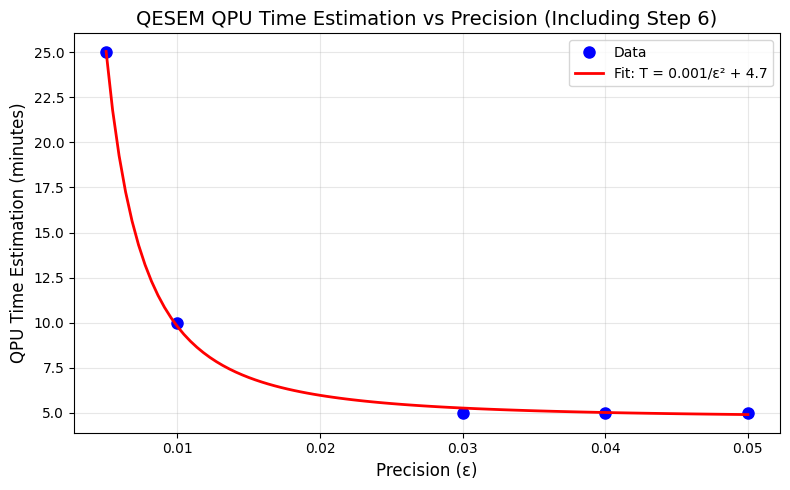

In [114]:
# Get the time estimation result
time_estimate_result = job_ex4_2.result()
step6_time_estimation = time_estimate_result[0].metadata['time_estimation_sec']

print(f"Step 6 time estimation: {step6_time_estimation} seconds")

# Add the new data point to existing arrays
precisions_updated = precisions_ex4 + [precision_ex4_2]
time_estimations_updated = time_estimations + [step6_time_estimation]

# Plot the updated graph with the new data point
print("\nUpdated graph with Step 6 data point:")
plot_qpu_time_vs_precision(precisions_updated, time_estimations_updated, " (Including Step 6)")

<div class="alert alert-block alert-success">

<b> Exercise 4.3:</b>

If you are satisfied with the time estimation go ahead and run the full QESEM error mitigation on our 5-qubit, 10-step Kicked Ising circuit with precision ε. In a case of real QPU, This will take QPU time according to your estimation result.
Complete the QESEM job parameters accordingly.
We will define max execution time as 10 minutes. Again, this setting is mainly relevant for real hardware experiments and will not limit simulation-based examples.

</div>

In [115]:
max_execution_time_ex4_3 = 600

### Test parameters

In [116]:
message = grader.grade_ex_4_3_qf(max_execution_time_ex4_3=max_execution_time_ex4_3)
print(message)

Congratulations! 🎉 Your answer is correct.


### Start a job only if parameter check passed

In [117]:
if message == grader.CORRECT_MESSAGE:  # Run the job only if parameters are correct
    # Start a job
    # Submit actual mitigation job
    job_ex4_2 = qesem_function.run(
            pubs=[(circuit_ex4_2, observables_ex4_2, [], precision_ex4_2)],
            instance=ibm_instance,
            backend_name=backend_ex4_2,
            options={
                "max_execution_time": max_execution_time_ex4_3,
            }
        )

    print(f"QESEM mitigation job submitted: {job_ex4_2.job_id}")
    print("Job is running... This may take several minutes.")

else:
    print(message)
    print("Parameter check failed, job did not start.")

QESEM mitigation job submitted: ce03625e-4cc5-4886-b5ce-b6804f84e9c6
Job is running... This may take several minutes.


<a id="tips"></a>
<div class="alert alert-block alert-info">

<b> Tip:</b> Use this code cell to check your job's status.

In [130]:
job_ex4_2.status()

'DONE'

Extract and analyze the QESEM results, comparing ideal, noisy, and error-mitigated expectation values to demonstrate the effectiveness of QESEM.


In [137]:

# Get the mitigated results
qesem_job_results = job_ex4_2.result()[0]
print("Job completed successfully!")
noisy_results = qesem_job_results.metadata["noisy_results"]

# Extract results for our observable
mitigated_expectation = qesem_job_results.data.evs[0]
mitigated_std = qesem_job_results.data.stds[0]

# Get noisy results for comparison
noisy_expectation = noisy_results.evs[0]
noisy_std = noisy_results.stds[0]

# Calculate ideal value for comparison
ideal_expectation = qiskit.quantum_info.Statevector(circ_ex4).expectation_value(observable_ex4).real

# Display comprehensive results summary
print("\n" + "=" * 60)
print("EXERCISE 4 - QESEM RESULTS SUMMARY")
print("=" * 60)
print(f"Observable: Global Z measurement (Z^⊗{n_qubits_ex4})")
print(f"Circuit: {n_steps_ex4}-step Kicked Ising, {n_qubits_ex4} qubits")
print(f"Precision target: {precision_ex4_2}")
print("-" * 60)
print(f"Ideal value:      {ideal_expectation:.6f}")
print(f"Noisy value:      {noisy_expectation:.6f} ± {noisy_std:.6f}")
print(f"QESEM value:      {mitigated_expectation:.6f} ± {mitigated_std:.6f}")
print("-" * 60)
print(f"Noisy error:      {abs(noisy_expectation - ideal_expectation):.6f}")
print(f"QESEM error:      {abs(mitigated_expectation - ideal_expectation):.6f}")
print(f"Error reduction:  {abs(noisy_expectation - ideal_expectation)/abs(mitigated_expectation - ideal_expectation if mitigated_expectation != ideal_expectation else 1):.1f}x")
print("-" * 60)
print(f"QESEM within target precision: {'✓' if abs(mitigated_expectation - ideal_expectation) <= precision_ex4_2 else '✗'}")
print("-" * 60)
# Additional detailed metrics
# As it is a simulation, this will be 0
print(f"Total QPU time: \n {qesem_job_results.metadata['total_qpu_time']:.6f}")

print(f"Gates fidelity measured during the experiment: \n {qesem_job_results.metadata['gate_fidelities']}")
print(f"Total shots / mitigation shots: \n {qesem_job_results.metadata['total_shots']} / {qesem_job_results.metadata['mitigation_shots']}")
print("="*60)

Job completed successfully!

EXERCISE 4 - QESEM RESULTS SUMMARY
Observable: Global Z measurement (Z^⊗5)
Circuit: 10-step Kicked Ising, 5 qubits
Precision target: 0.04
------------------------------------------------------------
Ideal value:      0.504065
Noisy value:      0.377600 ± 0.010505
QESEM value:      0.520967 ± 0.020046
------------------------------------------------------------
Noisy error:      0.126465
QESEM error:      0.016901
Error reduction:  7.5x
------------------------------------------------------------
QESEM within target precision: ✓
------------------------------------------------------------
Total QPU time: 
 0.000000
Gates fidelity measured during the experiment: 
 {'ID1Q': 0.9991053505467173, 'RZZ': 0.9952371913001917}
Total shots / mitigation shots: 
 342528 / 90000


<div style="
    padding: 20px;
    border-left: 8px solid #ff7f0e;
    border-radius: 8px;
    font-size: 16px;
">
<h3>🔥 Optional – QESEM on Real Hardware</h3>


<p>
Now that you've completed this notebook, you can run the same exercises on IBM’s real devices.
The code below runs the 20-qubit, 10-step Kicked Ising simulation on ibm_marrakesh. We'll measure here the avergae magnetization.
</p>

</div>


In [142]:
max_execution_time_ex_bonus = 900
n_qubits_ex_bonus = 20  # Number of qubits
n_steps_ex_bonus = 10  # Number of Trotter steps


theta_x_ex_bonus = theta_x_ex4 #math.pi / 6  # Rotation angle for X gates (transverse field strength)
theta_zz_ex_bonus = theta_zz_ex4 #math.pi / 3  # Rotation angle for ZZ gates (interaction strength)

circuit_ex_bonus = kicked_ising_1d(n_qubits_ex_bonus, theta_x=theta_x_ex_bonus, theta_zz=theta_zz_ex_bonus, num_steps=n_steps_ex_bonus)

avg_magnetization_ex_bonus = qiskit.quantum_info.SparsePauliOp.from_sparse_list([("Z", [q], 1 /n_qubits_ex_bonus ) for q in range(n_qubits_ex_bonus)], num_qubits=n_qubits_ex_bonus)

observables_ex_bonus = [avg_magnetization_ex_bonus]


##### Ideal expectation values
You can compute these using either `statevector`, or with `matrix_product_state` method. The latter is faster and uses less memory.

In [143]:
# # Calculate ideal value for comparison
# ideal_expectation = qiskit.quantum_info.Statevector(circuit_ex_bonus).expectation_value(observables_ex_bonus).real

backend = AerSimulator(method="matrix_product_state")
estimator = BackendEstimatorV2(backend=backend)
pub = (circuit_ex_bonus, observables_ex_bonus)
job = estimator.run([pub])
result = job.result()

ideal_expectation_mps = result[0].data.evs[0]
ideal_std_mps =  result[0].data.stds[0]


In [144]:
ideal_expectation_mps

np.float64(0.6330810546875)

In [145]:
#you may use this for comparison, computed with statevector
ideal_expectation_statevector = 0.6327159030578525
ideal_expectation = ideal_expectation_statevector

In [146]:
precision_ex_bonus = 0.05
backend_ex_bonus = "ibm_marrakesh"

job_ex_bonus_emp_est = qesem_function.run(
        pubs=[(circuit_ex_bonus, observables_ex_bonus, [], precision_ex_bonus)],
        instance=ibm_instance,
        backend_name=backend_ex_bonus,
        options={
            "estimate_time_only": "empirical",
            "max_execution_time": max_execution_time_ex_bonus,
        }
    )
print(f"Time estimation job submitted: {job_ex_bonus_emp_est.job_id}")

time_estimate_result_bonus = job_ex_bonus_emp_est.result()
bonus_time_estimation = time_estimate_result_bonus[0].metadata['time_estimation_sec']
print(f"Bonus time estimation: {bonus_time_estimation} seconds")



Time estimation job submitted: 3a5c8e38-e07d-4373-9b3a-72c62291ae55
Bonus time estimation: 300 seconds


Let's check the actual QPU time used by the empirical time estimation job:

In [148]:
print(f"Bonus QPU time: {time_estimate_result_bonus[0].metadata['total_qpu_time']} seconds")

Bonus QPU time: 69 seconds


In [179]:
#submit the mitigation job
print("starting the job")
job_ex_bonus = qesem_function.run(
        pubs=[(circuit_ex_bonus, observables_ex_bonus, [], precision_ex_bonus)],
        instance=ibm_instance,
        backend_name=backend_ex_bonus,
        options={
            "max_execution_time": max_execution_time_ex_bonus,
        }
    )
print(f"Mitigation job submitted: {job_ex_bonus.job_id}")


starting the job
Mitigation job submitted: a1de6e41-16e6-4d32-9d04-94d24cfe461d


In [186]:
job_ex_bonus.status()

'ERROR'

In [29]:
# Get the mitigated results
qesem_job_results_bonus = job_ex_bonus.result()[0]
print("Job completed successfully!")
noisy_results = qesem_job_results_bonus.metadata["noisy_results"]

# Extract results for our observable
mitigated_expectation = qesem_job_results_bonus.data.evs[0]
mitigated_std = qesem_job_results_bonus.data.stds[0]

# Get noisy results for comparison
noisy_expectation = noisy_results.evs[0]
noisy_std = noisy_results.stds[0]

In [154]:
job_ex_bonus.error_message()

['qiskit.exceptions.QiskitError: "\'Workflow execution failed -- https://docs.quantum.ibm.com/errors#9999\'"\n']

In [ ]:
#Define the results summary file name
output_file_txt = "real_hardware_bonus.txt"

results_summary = "\n" + "=" * 60 + "\n"
results_summary += "BONUS EXERCISE - QESEM RESULTS SUMMARY\n"
results_summary += "=" * 60 + "\n"
results_summary += f"Observable: Average Magnetization\n"
results_summary += f"Circuit: {n_steps_ex_bonus}-step Kicked Ising, {n_qubits_ex_bonus} qubits\n"
results_summary += f"Precision target: {precision_ex_bonus}\n"
results_summary += "-" * 60 + "\n"
results_summary += f"Ideal value:      {ideal_expectation:.6f}\n"
results_summary += f"Noisy value:      {noisy_expectation:.6f} ± {noisy_std:.6f}\n"
results_summary += f"QESEM value:      {mitigated_expectation:.6f} ± {mitigated_std:.6f}\n"
results_summary += "-" * 60 + "\n"
results_summary += f"Noisy error:      {abs(noisy_expectation - ideal_expectation):.6f}\n"
results_summary += f"QESEM error:      {abs(mitigated_expectation - ideal_expectation):.6f}\n"
results_summary += f"Error reduction:  {abs(noisy_expectation - ideal_expectation) / abs(mitigated_expectation - ideal_expectation if mitigated_expectation != ideal_expectation else 1):.1f}x\n"
results_summary += "-" * 60 + "\n"
results_summary += f"QESEM within target precision: {'✓' if abs(mitigated_expectation - ideal_expectation) <= precision_ex_bonus else '✗'}\n"
results_summary += "-" * 60 + "\n"
results_summary += f"Total QPU time: \n {qesem_job_results_bonus.metadata['total_qpu_time']:.6f}"
results_summary += f"Gates fidelity measured during the experiment: \n {qesem_job_results_bonus.metadata['gate_fidelities']}"
results_summary += f"Total shots / mitigation shots: \n {qesem_job_results_bonus.metadata['total_shots']} / {qesem_job_results_bonus.metadata['mitigation_shots']}"
results_summary += "=" * 60 + "\n"

#Print the results
print(results_summary)

# Save results to a txt file
with open(output_file_txt, "w") as f:
    f.write(results_summary)

<hr style="border: 0.7px solid #bbb; margin: 10px 0;">
<hr style="border: 0.7px solid #bbb; margin: 10px 0;">


## Additional Information
If you have any questions or need further assistance, feel free to reach out:

Ori Alberton, Lead Quantum Scientist, Qedma
<br> Email: Ori.Alberton@Qedma.com

Asaf Berkovitch, VP Product, Qedma <br> Email: Asaf.Berkovitch@Qedma.com
<br>
<br>
Created by: The Qedma Team